### Citibike Usage Seasonal Dynamic
Priya Khokher, Yuan Lai, Sachin Verma
#### Introduction:
Citibike data shows that there is a relatively low bike useage during winter time. It is presumed that many subscribers follow a pattern in trip duration, such as grocery shopping or commuting. However, it is not clear that wether there is a seasonal dynamic in such usage pattern. In this research, we look into citibike data generated by subscribers in summer months (July and August, 2015) and winter months (January and Febuary, 2015), in order to compare the seasonal difference in trip duration generated by subscribers. 


#### Hypothesis Development:
In this research, we question if there is a significant difference between the mean of trip duration in summer months and winter months by subscribers. To test H0:  mu1 - mu2  = 0 against Ha: mu1 - mu2 not eaqual zero.

We define the null hypothesis as: There is no difference in the average trip duration of subscribers in summer months as compared to the winter months. Significance level  $\alpha=0.05$

In [2]:
from __future__ import print_function
__author__='ylai'

%pylab inline
import pandas as pd
import os
import sys
import numpy as np
from scipy.stats import norm
from scipy import stats
from scipy.optimize import curve_fit, minimize
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
import pylab as pl
import json
s = json.load( open('ylai_matplotlibrc.json') )
pl.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


/Users/ericlaibuffalo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# Create a data frame named as 'summer' including data from July and August 2015.
jul = pd.read_csv("201507-citibike-tripdata.csv")
aug = pd.read_csv("201508-citibike-tripdata.csv")
summer = pd.concat([jul, aug], axis = 0)

jan = pd.read_csv("201501-citibike-tripdata.csv")
feb = pd.read_csv("201502-citibike-tripdata.csv")
winter = pd.concat([jan, feb], axis = 0)

In [4]:
len(summer)

2264720

In [5]:
len(winter)

482482

In [6]:
# Subset a dataframe with subscribers only.
summer_sub = summer[summer['usertype'] == 'Subscriber']
winter_sub = winter[winter['usertype'] == 'Subscriber']

In [7]:
summer_sub[:5]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,732,7/1/2015 00:00:03,7/1/2015 00:12:16,489,10 Ave & W 28 St,40.750664,-74.001768,368,Carmine St & 6 Ave,40.730386,-74.002150,18669,Subscriber,1970,1
1,322,7/1/2015 00:00:06,7/1/2015 00:05:29,304,Broadway & Battery Pl,40.704633,-74.013617,3002,South End Ave & Liberty St,40.711512,-74.015756,14618,Subscriber,1984,1
2,790,7/1/2015 00:00:17,7/1/2015 00:13:28,447,8 Ave & W 52 St,40.763707,-73.985162,358,Christopher St & Greenwich St,40.732916,-74.007114,18801,Subscriber,1992,1
3,1228,7/1/2015 00:00:23,7/1/2015 00:20:51,490,8 Ave & W 33 St,40.751551,-73.993934,250,Lafayette St & Jersey St,40.724561,-73.995653,19137,Subscriber,1990,1
4,1383,7/1/2015 00:00:44,7/1/2015 00:23:48,327,Vesey Pl & River Terrace,40.715338,-74.016584,72,W 52 St & 11 Ave,40.767272,-73.993929,15808,Subscriber,1988,1


In [8]:
len(summer_sub)

1863362

In [9]:
summer_sub['tripduration'].describe()

count    1863362.000000
mean         811.243927
std         5576.340963
min           60.000000
25%          382.000000
50%          602.000000
75%          960.000000
max      3611666.000000
Name: tripduration, dtype: float64

In [10]:
#We suspect there are outliers in our observations, therefore we need to clean
summer_dur = summer_sub['tripduration']
summer_dur_clean = summer_dur[(np.abs(stats.zscore(summer_dur)) < 3)]

winter_dur = winter_sub['tripduration']
winter_dur_clean = winter_dur[(np.abs(stats.zscore(winter_dur)) < 3)]

In [11]:
summer_dur_clean.describe()

count    1861956.000000
mean         757.325643
std          616.740416
min           60.000000
25%          382.000000
50%          601.000000
75%          959.000000
max        17530.000000
Name: tripduration, dtype: float64

In [12]:
winter_dur_clean.describe()

count    472979.000000
mean        606.803974
std         403.792930
min          60.000000
25%         334.000000
50%         499.000000
75%         753.000000
max        3179.000000
Name: tripduration, dtype: float64

In [13]:
fig=pl.figure(figsize(15,15))
# Create trip duration bins, in this case we use 180 seconds (3 mins) as interval for the bins.
bins = np.arange(60, 4000, 180)

# Aggregates of trip duration:
ag_summer = summer_dur_clean.groupby(pd.cut(summer_dur_clean, bins)).agg([count_nonzero])
ag_winter = winter_dur_clean.groupby(pd.cut(winter_dur_clean, bins)).agg([count_nonzero])
ag_summer[:10]

,count_nonzero
tripduration,
"(60, 240]",162855
"(240, 420]",389737
"(420, 600]",376281
"(600, 780]",278427
"(780, 960]",190219
"(960, 1140]",132285
"(1140, 1320]",94049
"(1320, 1500]",68051
"(1500, 1680]",50284


In [14]:
ag_winter[:10]

,count_nonzero
tripduration,
"(60, 240]",53197
"(240, 420]",128993
"(420, 600]",111310
"(600, 780]",69319
"(780, 960]",40753
"(960, 1140]",23999
"(1140, 1320]",15323
"(1320, 1500]",10113
"(1500, 1680]",6676


In [68]:
ag_winter.columns = ['Winter Trip Duration']
ag_summer.columns = ['Summer Trip Duration']

In [69]:
# Then we would like to know the percentage of trips by trip duration in these two distributions:
per_sum = (ag_summer/len(summer_dur_clean))*100
per_win = (ag_winter/len(winter_dur_clean))*100

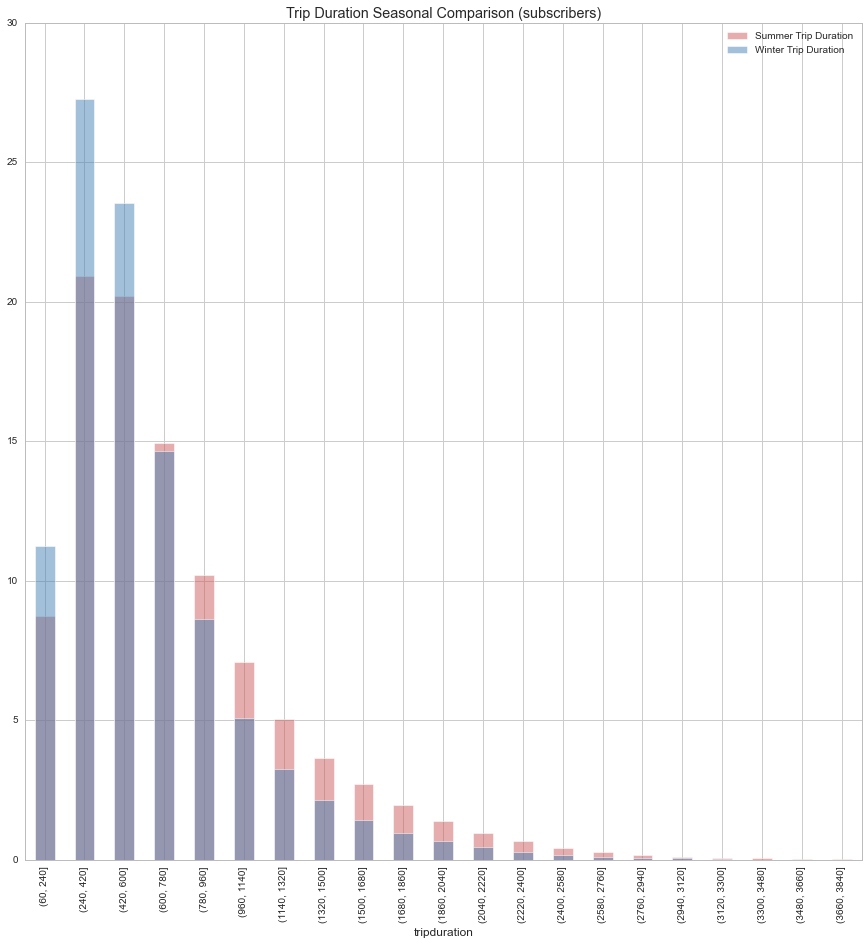

In [72]:
# Plot two trip duration distributions to compare the seasonal dynamic in trip duration.

fig = plt.figure(figsize(15,15))
ax = plt.subplot(111)
per_sum.plot(kind="bar", color = "IndianRed", alpha = 0.5, ax=ax, title = "Trip Duration Seasonal Comparison (subscribers)", label = "Summer Trip Duration")
ax = per_win.plot(kind="bar", alpha = 0.5, ax=ax)


#### Data Inference:
Based on the plot above, we notice that more percentage of subscibers taking short trips in winter time, especially the short trips ranging from 4 mins to 7 min.

#### Hypothesis Testing:
Since the summer and winter data are two separate and independent groups, and we wonder about the average trip duration, we use two sample z-test to test H0:  mu1 - mu2  = 0 against Ha: mu1 - mu2 not eaqual zero.
Significance level  $\alpha=0.05$

In [36]:
#In this study, we want to compare two means of trip duration in summer time and winter time. Therefore we define:
mean_s = np.mean(summer_dur_clean)
mean_w = np.mean(winter_dur_clean)
n_s = len(summer_dur_clean)
n_w = len(winter_dur_clean)
sd_s = np.std(summer_dur_clean, axis=0)
sd_w = np.std(winter_dur_clean, axis=0)
mudiff = 0

In [37]:
print (mean_s, mean_w, n_s, n_w,sd_s, sd_w )

757.325643033 606.803974384 1861956 472979 616.740250148 403.792502732


In [38]:
#Then we would like to use z-score to test these two means.

In [39]:
def twoSampZ(mean_s, mean_w, mudiff, sd_s, sd_w, n_s, n_w):
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    pooledSE = sqrt(sd_s**2/n_s + sd_w**2/n_w)
    z = ((mean_s - mean_w) - mudiff)/pooledSE
    pval = 2*(1 - norm.cdf(abs(z)))
    return round(z, 3), round(pval, 4)

In [40]:
z, p = twoSampZ(mean_s, mean_w, 0, sd_s, sd_w, n_s, n_w)
print (z, p)

203.146 0.0


Based on the z-score we check the z-score table to find out: p(z > 3.4) = 0.9997 
Our p value is really small which eaquals zero. Two sample z-tests are rarely used, because the estimate for the SE for difference used here is biased. Instead, statisticians use a two-sample t-test:

In [41]:
#T-test with different means, variance, and n:
stats.ttest_ind(summer_dur_clean, winter_dur_clean, equal_var = False)

(203.14597565995052, 0.0)

#### Therefore we can reject the null hypothesis and state that there is a trip duration difference between summer time and winter time. 